In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [7]:
import collections
import math
import os
import random
from tempfile import gettempdir
import zipfile

In [8]:
import numpy as np
from six.moves import urllib
from six.moves import xrange
import tensorflow as tf

In [9]:
# download the data
url = 'http://mattmahoney.net/dc/'

In [10]:
def maybe_download(filename,expected_bytes):
    local_filename = os.path.join(gettempdir(),filename)
    if not os.path.exists(local_filename):
        local_filename, _ = urllib.request.urlretrieve(url+filename,local_filename)
    statinfo = os.stat(local_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:        
        print(statinfo.st_size)
        raise Exception('Failed to verify: '+local_filename+'. Can you get to it with a browser?')
    return local_filename

In [11]:
filename = maybe_download('text8.zip',31344016)

Found and verified text8.zip


In [12]:
def read_data(filename):
    # extract the first file enclosed in a zip file as a list of words
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

In [13]:
vocabulary = read_data(filename)

In [14]:
vocabulary_size = 50000

In [15]:
def build_dataset(words,n_words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _  in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word,0)
        if index==0:
            unk_count+=1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(),dictionary.keys()))
    return data,count,dictionary,reversed_dictionary
        

In [16]:
data, count, dictionary, reverse_dictionary = build_dataset(vocabulary,vocabulary_size)

In [17]:
del vocabulary # reduce memory

In [18]:
print('Most common words (+UNK)', count[:5])

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]


In [19]:
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [20]:
data_index = 0

In [21]:
# implement skipgram
def generate_batch(batch_size,num_skips,skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips<=2 * skip_window
    batch = np.ndarray(shape=(batch_size),dtype=np.int32)
    labels = np.ndarray(shape=(batch_size,1),dtype=np.int32)
    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index+span])
    data_index+=span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w!= skip_window]
        random.shuffle(context_words)
        words_to_use = collections.deque(context_words)
        for j in range(num_skips):
            batch[i*num_skips+j] = buffer[skip_window]
            context_word = words_to_use.pop()
            labels[i*num_skips+j,0] = buffer[context_word]
        if data_index == len(data):
            buffer[:] = data[:span]
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
        # backtrack a little bit to avoid skipping words
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels            

In [22]:
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]], '->',labels[i,0], reverse_dictionary[labels[i,0]])

3081 originated -> 5234 anarchism
3081 originated -> 12 as
12 as -> 6 a
12 as -> 3081 originated
6 a -> 195 term
6 a -> 12 as
195 term -> 6 a
195 term -> 2 of


In [23]:
batch_size = 128
embedding_size = 128
skip_window = 1
num_skips = 2

In [24]:
valid_size = 16
valid_window = 100
valid_examples = np.random.choice(valid_window,valid_size, replace=False)
num_sampled = 64

In [25]:
graph = tf.Graph()

In [26]:
with graph.as_default():
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size,1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    with tf.device('/cpu:0'):
        # make random uniform initialization
        embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size],-1.0,1.0))
        embed = tf.nn.embedding_lookup(embeddings,train_inputs)
    
    nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size,embedding_size],stddev=1.0/math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
    loss = tf.reduce_mean(
    tf.nn.nce_loss(weights=nce_weights,
                   biases=nce_biases,
                   labels=train_labels,
                   inputs=embed,
                   num_sampled=num_sampled,
                   num_classes=vocabulary_size))
    
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings),1,keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,valid_dataset)
    similarity = tf.matmul(valid_embeddings,normalized_embeddings,transpose_b=True)
    
    # add variable initializer
    init = tf.global_variables_initializer()

In [27]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    init.run()
    print('initalized')
    
    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(batch_size,num_skips,skip_window)
        feed_dict={train_inputs: batch_inputs, train_labels: batch_labels}
    
    _, loss_val = session.run([optimizer,loss], feed_dict=feed_dict)
    average_loss+=loss_val
    if step % 2000 == 0:
        if step > 0:
            average_loss /=2000
        print('Average loss at step ',step,':',average_loss)
        average_loss = 0
    if step % 10000 ==0 :
        sim = similarity.eval()
        for i in xrange(valid_size):
            valid_word = reverse_dictionary[valid_examples[i]]
            top_k = 8
            nearest = (-sim[i,:]).argsort()[1:top_k+1]
            log_str = 'Nearest to %s: ' % valid_word
            for k in xrange(top_k):
                close_word = reverse_dictionary[nearest[k]]
                log_str = '%s %s,' %(log_str,close_word)
            print(log_str)
    final_embeddings = normalized_embeddings.eval()

initalized
Average loss at step  100000 : 0.139434570313
Nearest to he:  zeke, gimps, focusing, adl, abbasids, ene, pectin, stereo,
Nearest to would:  sive, greyhound, ergodic, hearses, swaim, cultivars, appraisal, absorptive,
Nearest to b:  chih, fripp, seeking, disco, snowboarding, kong, reis, dashiell,
Nearest to been:  edition, humanist, parse, negotiators, balzac, strengthens, phylogenetic, parlance,
Nearest to with:  ep, leveled, elamites, qwerty, trigrams, lamb, balliol, tenants,
Nearest to such:  stink, uttering, edmonton, gulden, evolves, shires, nilotic, wicked,
Nearest to than:  enlai, sucks, microcomputers, nubia, communicator, pictures, villas, quatre,
Nearest to more:  vengeance, racial, saviour, crystallization, israelite, semen, achievements, hispaniola,
Nearest to three:  edomites, constraint, korzybski, albion, pyrenees, museums, corrado, unnamed,
Nearest to on:  universal, slows, worldcom, lineker, haag, diu, antibiotics, chlorine,
Nearest to history:  morocco, pesky

In [28]:
# visualization
def plot_with_labels(low_dim_embs, labels,filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18,18))
    for i,label in enumerate(labels):
        x,y = low_dim_embs[i,:]
        plt.scatter(x,y)
        plt.annotate(label,xy=(x,y),xytext=(5,2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')
    plt.savefig(filename)

In [29]:
%matplotlib inline
try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    
    tsne = TSNE(perplexity=30,n_components=2,init='pca',n_iter=5000,method='exact',verbose=2)
    plot_only = 5000
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs,labels,os.path.join(gettempdir(),'tsne.png'))
except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings')
    print(ex)
    
    

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.208186
[t-SNE] Iteration 25: error = 27.0933753, gradient norm = 0.0686667
[t-SNE] Iteration 50: error = 27.6360742, gradient norm = 0.0538284
[t-SNE] Iteration 75: error = 26.7858986, gradient norm = 0.0699780
[t-SNE] Iteration 100: error = 27.2040541, gradient norm = 0.0564550
[t-SNE] KL divergence after 100 iterations with early exaggeration: 27.204054
[t-SNE] Iteration 125: error = 4.6311773, gradient norm = 0.0021487
[t-SNE] Iteration 150: error = 4.5216555, gradient norm = 0.0013426
[t-SNE] Iteration 175: error = 4.4966021, gradient norm = 0.0012692
[t-SNE] Iteration 200: error = 4.4900468, grad

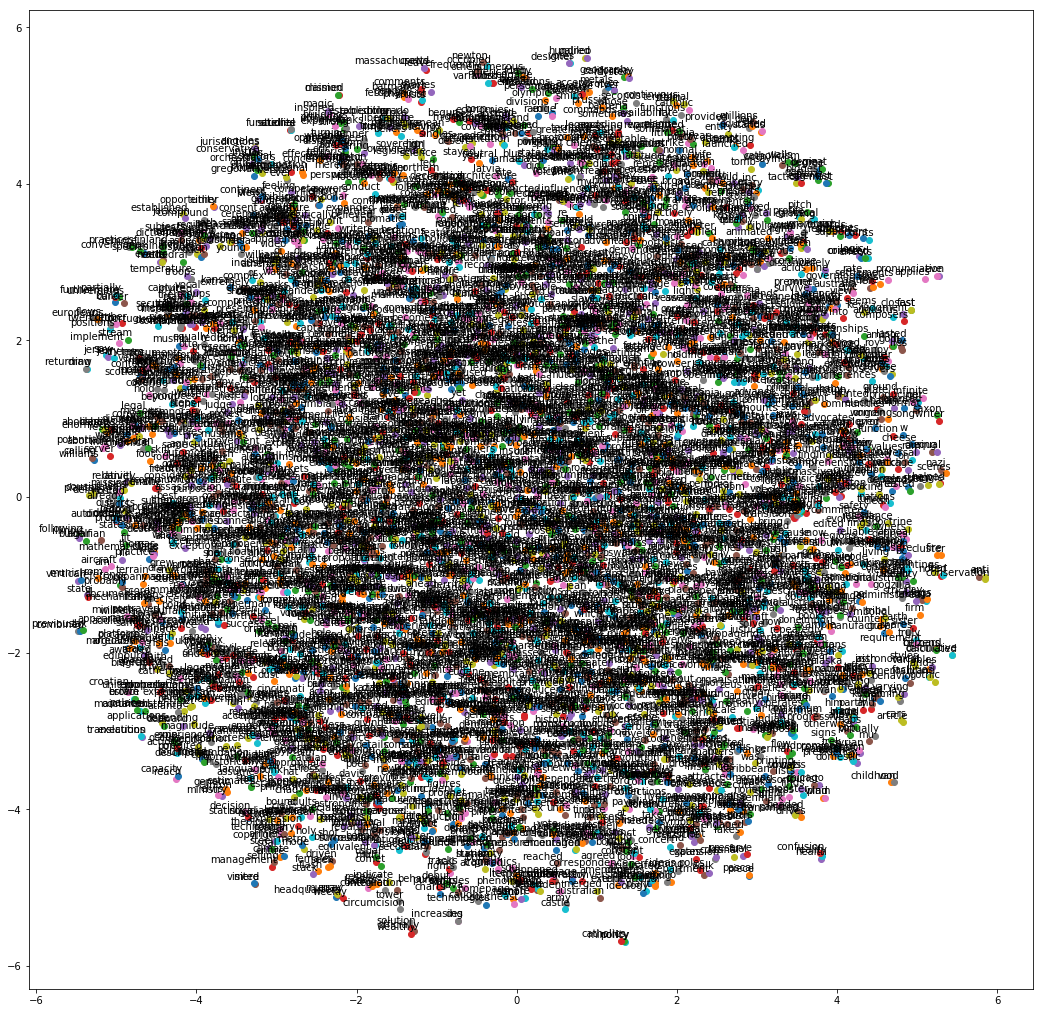

In [30]:
%matplotlib inline
plot_with_labels(low_dim_embs,labels,os.path.join(gettempdir(),'tsne.png'))

In [59]:
import pandas as pd
import numpy as np

In [2]:
ethnea_df = pd.read_csv('names_ethnea_genni_country_sample.csv')

In [3]:
ethnea_df

,AUID,Last,First,Ethnea,Genni,PubCountry
0,12872768_1,_Filho_,_Elias_Abdalla_,HISPANIC,M,Brazil
1,12565879_3,_Bou_Abdallah_,_Jad_,ARAB,M,France
2,17569133_1,_Abdel_Aziz_,_Ayman_,ARAB,M,USA
3,11213157_2,_Abdelmoula_,_Salma_,ARAB,F,Tunisia
4,11439058_1,_Abdou_,_Ibrahim_,ARAB,M,Egypt
5,10919608_3,_Abou_El_Fettouh_,_Hazem_,ARAB,M,USA
6,17314740_3,_Aboutaam_,_Rola_,ARAB,F,France
7,16564217_2,_Alvim_de_Abreu_Silva_Rodrigues_,_Aida_Alexandra_,HISPANIC,F,Brazil
8,6339395_2,_Cristina_Affonso_Scaletsky_,_Isabel_,HISPANIC,F,Brazil
9,7796089_2,_Agbenyega_,_Tsiri_,AFRICAN,-,Ghana


In [94]:
#combine first_name and last_name
name_series = ethnea_df['Last'] + ethnea_df['First']
name_series = name_series.replace('_',' ',regex=True)
name_series = name_series.str.strip()
name_series = name_series.str.upper()

#extract ethnicity rows
ethnic_list = ethnea_df.Ethnea.values

In [95]:
#make a name vector from all the dataset
name_dict = {}
for i,name_list in enumerate(name_series.str.split(' ')):
    for name in name_list:
        if name != '':
            if name not in name_dict:
                name_dict[name] = []
            name_dict[name].append(ethnic_list[i])

In [96]:
len(name_dict)

34834

In [97]:
name_dict

{'FILHO': ['HISPANIC',
  'HISPANIC',
  'HISPANIC',
  'HISPANIC',
  'HISPANIC',
  'HISPANIC',
  'HISPANIC',
  'HISPANIC',
  'HISPANIC',
  'HISPANIC',
  'HISPANIC'],
 'ELIAS': ['HISPANIC',
  'HISPANIC',
  'HISPANIC',
  'ARAB',
  'ARAB',
  'ENGLISH',
  'HISPANIC',
  'HISPANIC',
  'HISPANIC',
  'GREEK'],
 'ABDALLA': ['HISPANIC', 'ARAB', 'ARAB', 'ARAB'],
 'BOU': ['ARAB'],
 'ABDALLAH': ['ARAB', 'ARAB', 'ARAB', 'FRENCH'],
 'JAD': ['ARAB'],
 'ABDEL': ['ARAB',
  'ARAB',
  'ARAB',
  'ARAB',
  'ARAB',
  'ARAB',
  'ARAB',
  'ARAB',
  'ARAB',
  'ARAB',
  'ARAB'],
 'AZIZ': ['ARAB', 'ARAB', 'ARAB', 'ARAB', 'ARAB'],
 'AYMAN': ['ARAB', 'ARAB'],
 'ABDELMOULA': ['ARAB', 'ARAB'],
 'SALMA': ['ARAB', 'ARAB'],
 'ABDOU': ['ARAB'],
 'IBRAHIM': ['ARAB',
  'ARAB',
  'ARAB',
  'ARAB',
  'ARAB',
  'ARAB',
  'AFRICAN',
  'AFRICAN',
  'ARAB',
  'ARAB',
  'ARAB',
  'ARAB',
  'ARAB',
  'ARAB',
  'ARAB',
  'TURKISH',
  'ARAB',
  'ARAB'],
 'ABOU': ['ARAB', 'ARAB', 'ARAB', 'ARAB', 'ARAB'],
 'EL': ['ARAB',
  'ARAB',
  'AR

In [98]:
# assume ethnic is a document
ethnic_dict = {}
for i,ethnic_i in enumerate(ethnic_list):
    if ethnic_i not in ethnic_dict:
        ethnic_dict[ethnic_i] = []
    # split the name
    split_name = name_series[i].split(' ')
    for name_j in split_name:
        if name_j!='':
            ethnic_dict[ethnic_i].append(name_j)

In [99]:
ethnic_list = list(ethnic_dict.keys())
name_list = list(name_dict.keys())

In [107]:
#calculate tf
# prepare tf-idf matrix
tf_idf = np.zeros( [len(name_dict),len(ethnic_dict)])
idf = np.zeros( len(name_dict) )
total_name_on_eth = np.zeros( len(ethnic_dict) ) 
for name,ethnic in name_dict.items():
    ethnic_tracer = []
    for ethnic_i in ethnic:
        if ethnic_i not in ethnic_tracer:
            idf[name_list.index(name)]+=1
            ethnic_tracer.append(ethnic_i)
        tf_idf[name_list.index(name),ethnic_list.index(ethnic_i)]+=1
        total_name_on_eth[ethnic_list.index(ethnic_i)]+=1
        #compute the tf and assign it to tf_idf
    idf[name_list.index(name)] = np.log(len(ethnic_list)/idf[name_list.index(name)])
    
# compute tf
for i,ethnic_i in enumerate(ethnic_list):
    tf_idf[:,i] = tf_idf[:,i] / total_name_on_eth[i]

    
# multiply with the idf
for i,name_i in enumerate(name_list):
    tf_idf[i,:] = tf_idf[i,:]*idf[i]

In [108]:
tf_idf

array([[ 0.00319149,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00097115,  0.00114476,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.000226  ,  0.00239759,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [106]:
tf_idf[3]

array([ 0.        ,  0.00032723,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])